In [1]:
import sys
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
from kneed import KneeLocator
from scipy.ndimage import uniform_filter1d
from scipy import sparse

In [2]:
mallet_path = pathlib.Path("../data/models/mallet")
ctm_path = pathlib.Path("../data/models/ctm")
# bert_path = pathlib.Path("../data/models/bertopic")

In [3]:
annotation_paths = [
    "../data/json_out/config_first_round.json",
    "../data/json_out/config_second_round.json",
]
selected_topics_mallet = []
selected_topics_ctm = []
for path in annotation_paths:
    with open(path) as f:
        annotation_data = json.load(f)
    for topic in annotation_data["data/models/mallet"]:
        selected_topics_mallet.append(int(topic))
    for topic in annotation_data["data/models/ctm"]:
        selected_topics_ctm.append(int(topic))

In [4]:
def load_model_info(model_path):
    if model_path.stem == "mallet":
        thetas = np.load(model_path / "doctopics.npz.npy")
        betas = np.load(model_path / "beta.npy")
    elif model_path.stem == "ctm":
        thetas = np.load(model_path / "train.theta.npy")
        betas = np.load(model_path / "beta.npy")
    else:
        thetas = sparse.load_npz(pathlib.Path(model_path) / "thetas.npz").toarray()
        betas = np.load(model_path / "betas.npy")
    
    try:
        with open(model_path / "vocab.json") as infile:
            vocab_w2id = json.load(infile)
    except:
        vocab_w2id = {}
        with (pathlib.Path(model_path)/'vocab.txt').open('r', encoding='utf8') as fin:
            for i, line in enumerate(fin):
                wd = line.strip()
                vocab_w2id[wd] = i
    
    #bow = np.load(model_path / "bow_mat.npy")
    
    vocab_id2w = dict(zip(vocab_w2id.values(), vocab_w2id.keys()))
    keys = [
        [vocab_id2w[idx]
            for idx in row.argsort()[::-1][:15]]
        for row in betas
    ]
        
    return thetas, betas, vocab_w2id, keys

In [5]:
thetas_mallet, betas_mallet, vocab_w2id_mallet, keys_mallet = load_model_info(mallet_path)
thetas_ctm, betas_ctm, vocab_w2id_ctm, keys_ctm = load_model_info(ctm_path)
# thetas_bt, betas_bt, vocab_w2id_bt, keys_bt = load_model_info(bert_path)

In [6]:
def thrFig_logged(thetas32, thetas_thr=3e-3, poly_degree=3, smoothing_window=5, do_knee=True):
    significant_docs = {}
    all_elbows = []
    
    for k in range(len(thetas32.T)):
        allvalues = np.sort(thetas32[:, k].flatten())
        step = int(np.round(len(allvalues) / 1000))
        x_values = allvalues[::step]
        y_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
        
        # Apply smoothing
        y_values_smooth = uniform_filter1d(y_values, size=smoothing_window)

        plt.semilogx(x_values, y_values_smooth)
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            kneedle = KneeLocator(x_values, y_values_smooth, curve='concave', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)

                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]

        # Plot elbows
        for elbow in all_elbows:
            if elbow:
                plt.semilogx([elbow, elbow], [0, 100], 'g--', label=f'Elbow {elbow}')

    plt.show()
        
    return significant_docs, all_elbows


In [7]:
def thrFig(
        thetas32,
        topics=None,
        max_docs=1000,
        poly_degree=3,
        smoothing_window=5,
        do_knee=True,
        n_steps=1000,
        figsize=(10, 6),
        fontsize=12,
        output_fpath=None,
    ):
    significant_docs = {}
    all_elbows = []
    
    # use colorbrewer Set2 colors
    colors = plt.cm.Dark2(np.linspace(0, 1, thetas32.shape[1]))
    n_docs = thetas32.shape[0]
    print(max_docs)
    plt.figure(figsize=figsize)

    lines = []
    for k in range(len(thetas32.T)):
        theta_k = np.sort(thetas32[:, k])
        theta_over_th = theta_k[-max_docs:]
        step = max(1, int(np.round(len(theta_over_th) / n_steps)))
        y_values = theta_over_th[::step]
        x_values = np.arange(n_docs-max_docs, n_docs)[::step]

        # Apply smoothing
        x_values_smooth = uniform_filter1d(x_values, size=smoothing_window)

        label = None
        if topics is not None:
            label = topics[k]
        line, = plt.plot(x_values_smooth, y_values, color=colors[k], label=label)
        lines.append(line)
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            allvalues = np.sort(thetas32[:, k].flatten())
            step = int(np.round(len(allvalues) / 1000))
            theta_values = allvalues[::step]
            idx_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
            
            # Apply smoothing
            idx_values_smooth = uniform_filter1d(idx_values, size=smoothing_window)

            kneedle = KneeLocator(theta_values, idx_values_smooth, curve='concave', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)

                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]

        if elbow:
            # plot elbow in same color, smaller linewidth
            plt.plot([n_docs - max_docs, n_docs], [elbow, elbow], color=colors[k], linestyle='--', linewidth=1)

    # add legend where this series is named with the kth topic, do not assign to the 
    # elbow line
    if topics is not None:
        plt.legend(handles=lines, loc='upper left', fontsize=fontsize-1)

    # Add axis labels
    plt.xlabel('Document Index', fontsize=fontsize)
    plt.ylabel('Theta — P(k | d)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if output_fpath:
        # make bounding box extremely tight
        plt.savefig(output_fpath, bbox_inches='tight', pad_inches=0)

    plt.show()

    return significant_docs, all_elbows


1000


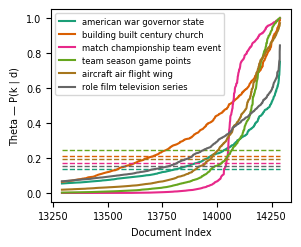

In [238]:
thetas_mallet.shape

1000


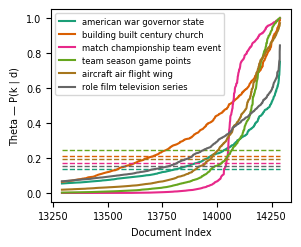

In [9]:
selected_top_words_mallet = [" ".join(keys_mallet[i][:4]) for i in selected_topics_mallet]

significant_docs, elbows = thrFig(
    thetas_mallet[:, selected_topics_mallet],
    topics=selected_top_words_mallet,
    max_docs=1000,
    do_knee=True,
    n_steps=5_000,
    figsize=(3.1, 2.5),
    fontsize=7,
    #output_fpath="../figures/thetas_mallet.pdf",
)

# save to pdf, taking up 3.1 x 2.5 inches

1000


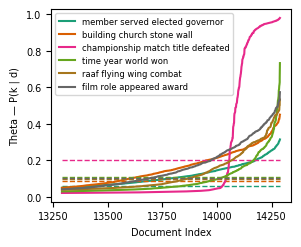

In [10]:
selected_top_words_ctm = [" ".join(keys_ctm[i][:4]) for i in selected_topics_ctm]

significant_docs, elbows = thrFig(
    thetas_ctm[:, selected_topics_ctm],
    topics=selected_top_words_ctm,
    max_docs=1000,
    do_knee=True,
    n_steps=5_000,
    figsize=(3.1, 2.5),
    fontsize=7,
    output_fpath="../figures/thetas_ctm.pdf",
)


1000


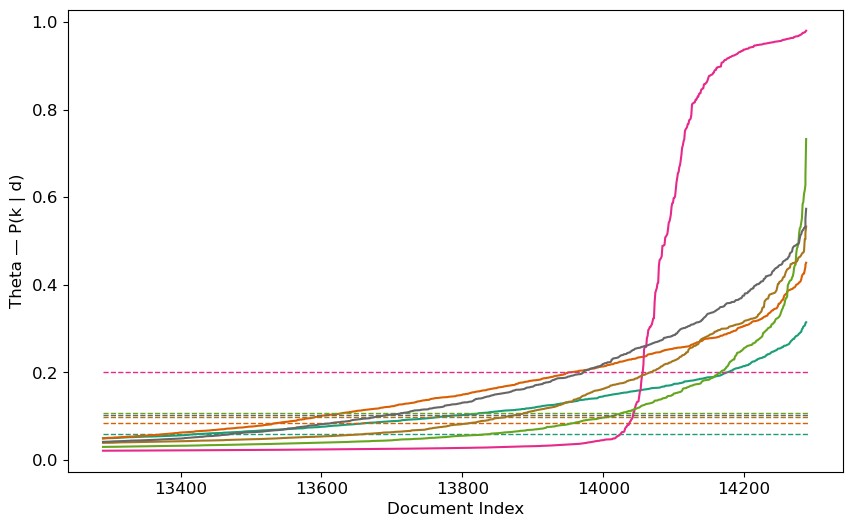

ELBOWS:  [0.05938452072441578, 0.084663306735456, 0.20040859133005143, 0.10796010978519917, 0.09731364902108908, 0.10238978005945683]
Significant documents for topic 0: 864
Significant documents for topic 1: 752
Significant documents for topic 2: 234
Significant documents for topic 3: 262
Significant documents for topic 4: 430
Significant documents for topic 5: 598


In [11]:
significant_docs, elbows = thrFig(thetas_ctm[:, selected_topics_ctm], do_knee=True)

print("ELBOWS: ", elbows)

for topic, docs in significant_docs.items():
    print(f"Significant documents for topic {topic}: {len(docs)}")

In [12]:
significant_docs, elbows = thrFig(thetas_bt, do_knee=False)
SaveThrFig(thetas_bt, path_save.joinpath("bertopic").as_posix(),thetas_thr=2*1e-2)


print("ELBOWS: ", elbows)

for topic, docs in significant_docs.items():
    print(f"Significant documents for topic {topic}: {len(docs)}")

NameError: name 'thetas_bt' is not defined

For BERTopic, most lines near the top indicating a few documents strongly represent each topic (makes sense since it's an approximation after hard clustering).